<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2008%20-%20Classification/Lecture_08_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMAGE CLASSIFICATION
In this jupyter notebook, we briefly reviewed well-known classifiers for image classification.


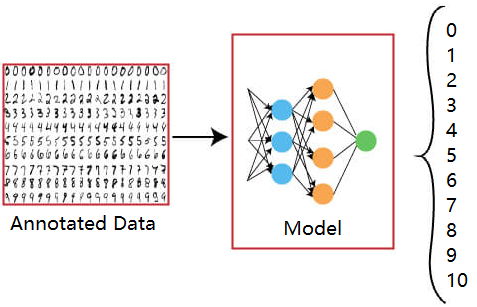

In [1]:
import numpy as np
import cv2, math
import matplotlib.pyplot as plt
#Keras to import datasets, not for deep learning (yet)
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn import metrics, preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import skimage.feature as feature


#Data Processing

This section collects the dataset and extracts the HOG features of each sample.

##Datasets

In [2]:
def load_digit_mnist():
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  lbls_name = ['0','1','2','3','4','5','6','7','8','9']

  return (x_train,y_train),(x_test, y_test),lbls_name

def load_fashion_mnist():
  (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
  lbls_name = ['0','1','2','3','4','5','6','7','8','9']

  return (x_train,y_train),(x_test, y_test),lbls_name

def load_cifar_10():
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  lbls_name = ['0','1','2','3','4','5','6','7','8','9']
  y_train = y_train.reshape(-1)
  y_test = y_test.reshape(-1)
  return (x_train,y_train),(x_test, y_test),lbls_name

In [3]:
(x_train,y_train),(x_test, y_test),lbls_name = load_digit_mnist()
#(x_train,y_train),(x_test, y_test),lbls_name = load_fashion_mnist()
#(x_train,y_train),(x_test, y_test),lbls_name = load_cifar_10()
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [4]:
#Auxiliary Function to plot side by side
def plot_sidebyside(img_list,titles=None,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  if titles is None:
    titles = []
    A = ord('A')
    for i in range(n):
      titles.append(chr(A+i))

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

##HOG Features
HoG – Histogram of Oriented Gradients
* Computes the gradient and orientation of edges
* Use a kernel to compute the Gradients (i.e 9x1)
* Patch-Based Histogram (8x8, 16x16..)


Below are exemplified the HOG features of an input image

In [5]:
class HOG:
  def describe(self,im,pixels_per_cell=(8, 8),cells_per_block=(2, 2)):
    if len(im.shape) > 2 and im.shape[2] == 3:
      im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

    im = cv2.resize(im,(64,128))

    fd, hog_image = feature.hog(im, orientations=9, pixels_per_cell=pixels_per_cell,
                	cells_per_block=cells_per_block,visualize=True)
    return fd,hog_image

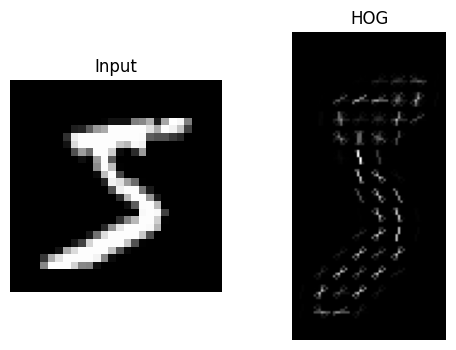

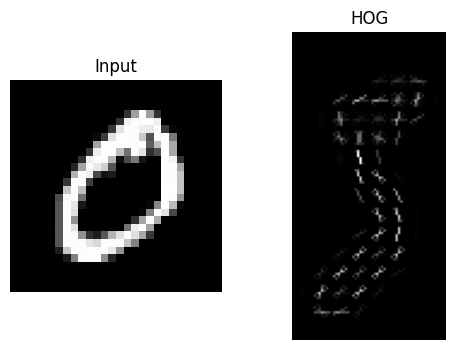

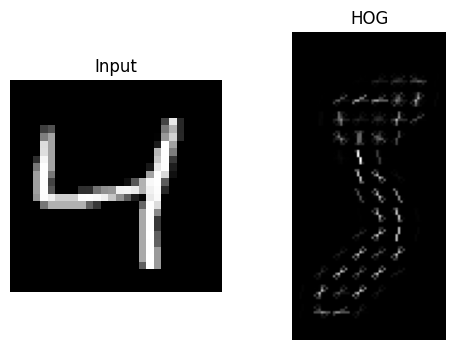

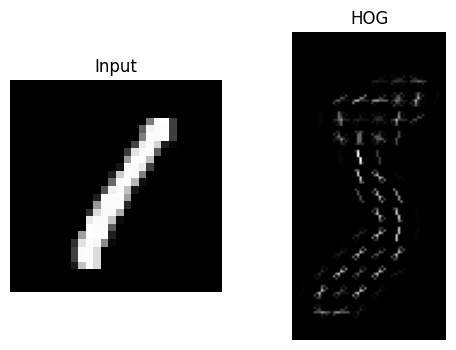

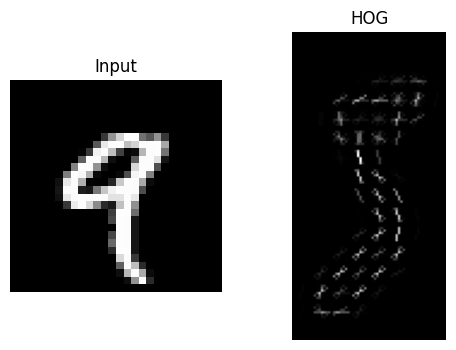

In [6]:
desc = HOG()
for img in x_train[:5]:
  key_pts, hog_img = desc.describe(x_train[0])
  plot_sidebyside([img,hog_img],
                ['Input','HOG'],
                colormap='gray',
                figsize=(6,4))


In [7]:
desc = HOG()

N_SAMPLES_TRAIN = 3000
N_SAMPLES_TEST = 500

features = {'train': [], 'test': []}
for img, lbl in zip(x_train[:N_SAMPLES_TRAIN],y_train[:N_SAMPLES_TRAIN]):

  feat, _ = desc.describe(img)
  features['train'].append(feat)

#Add to a dictionary
features['train'] = np.reshape(features['train'],(N_SAMPLES_TRAIN,-1))
print('Train Data: ',features['train'].shape)



for img, lbl in zip(x_test[:N_SAMPLES_TEST],y_test[:N_SAMPLES_TEST]):
  feat, _ = desc.describe(img)
  features['test'].append(feat)

#Add to a dictionary
features['test'] = np.reshape(features['test'],(N_SAMPLES_TEST,-1))
print('Test Data: ',features['test'].shape)




Train Data:  (3000, 3780)
Test Data:  (500, 3780)


#Data Normalization

Normalizing data is important in distorting differences in the ranges of values.

In [8]:
data = features['train']
print(data[0])

print(np.unique(data[0]))

print("STD Scaler")
data_norm = preprocessing.StandardScaler().fit_transform(data)
print(np.unique(data_norm[0]))

print("MinMax Scaler")
data_norm = preprocessing.MinMaxScaler().fit_transform(data)
print(np.unique(data_norm[0]))



[0. 0. 0. ... 0. 0. 0.]
[0.00000000e+00 3.02835824e-04 3.67174926e-04 ... 8.38030365e-01
 8.86406827e-01 9.99999999e-01]
STD Scaler
[-1.37626074 -1.35422276 -1.32495279 ... 13.28093758 13.44635507
 16.15608385]
MinMax Scaler
[0.00000000e+00 4.69501726e-04 5.99471266e-04 ... 9.84994133e-01
 9.96814690e-01 1.00000000e+00]


In [9]:
data_norm_train = preprocessing.MinMaxScaler().fit_transform(features['train'])
data_norm_test = preprocessing.MinMaxScaler().fit_transform(features['test'])

#Classification

This section evaluates several well-know classifiers

* KNN
* Logistic Regression
* Naive Bayes
* Decision Tree
* Support Vector Machine
* Multi-Layer Perceptron



In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

K=3
max_iter = 100

models = {}
models['KNN'] = KNeighborsClassifier(n_neighbors=3)
models['NB'] = MultinomialNB()
models['LR'] = LogisticRegression(max_iter=max_iter)
models['DT'] = DecisionTreeClassifier(max_depth=5)
models['SVC'] = SVC(max_iter=max_iter)
models['MLP'] = MLPClassifier(max_iter=max_iter)

In [11]:
def performance_evaluation(y_test, predictions,info_message,figsize=(18, 4)):

  print(f"Evaluation of ", info_message)
  print(f"{metrics.classification_report(y_test, predicted)}\n")
  print(lbls_name)
  disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)
  disp.figure_.suptitle("Confusion Matrix")
  plt.show()
  print('\n')
  id = np.random.randint(300)
  idx1,idx2=id,id+10
  diff = np.absolute(y_test.astype(np.int32) - predictions)
  idxs = np.where(diff == 0)

  _, axes = plt.subplots(nrows=1, ncols=(idx2-idx1), figsize=figsize)
  for ax, image, lbl, prediction, in zip(axes, x_test[idxs],y_test[idxs], predictions[idxs]):
      ax.set_axis_off()
      ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      ax.set_title(f'Label: {lbl}')
      ax.text(0.5, 0.0, f'Pred: {prediction}', ha='center', va='center', transform=ax.transAxes)

  idxs = np.where(diff != 0)
  plt.show()

  print('\n')
  _, axes = plt.subplots(nrows=1, ncols=(idx2-idx1), figsize=figsize)
  for ax, image, lbl, prediction, in zip(axes, x_test[idxs],y_test[idxs], predictions[idxs]):
      ax.set_axis_off()
      ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      ax.set_title(f'Label: {lbl}')
      ax.text(0.5, 0.0, f'Pred: {prediction}', ha='center', va='center', transform=ax.transAxes)
  plt.show()
  print('\n')

##Training and Evaluate

#########################
Training KNN
Evaluation of  KNN
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        42
           1       0.93      1.00      0.96        67
           2       1.00      0.93      0.96        55
           3       0.95      0.89      0.92        45
           4       0.94      0.89      0.92        55
           5       0.98      0.86      0.91        50
           6       0.98      0.95      0.96        43
           7       0.89      0.96      0.92        49
           8       0.90      0.90      0.90        40
           9       0.89      0.89      0.89        54

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


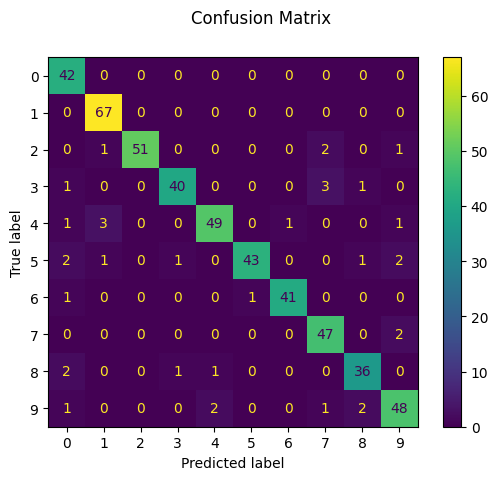

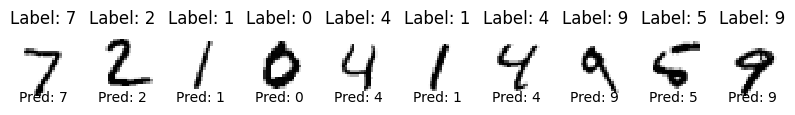

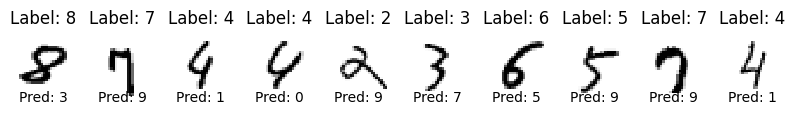



#########################
Training NB
Evaluation of  NB
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        42
           1       0.99      0.99      0.99        67
           2       0.96      0.91      0.93        55
           3       0.85      0.87      0.86        45
           4       0.85      0.96      0.91        55
           5       0.98      0.86      0.91        50
           6       0.95      0.95      0.95        43
           7       0.94      0.92      0.93        49
           8       0.79      0.82      0.80        40
           9       0.89      0.87      0.88        54

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.92      0.91      0.91       500


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


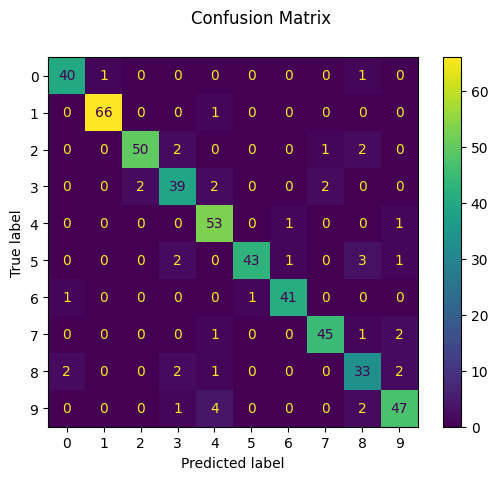

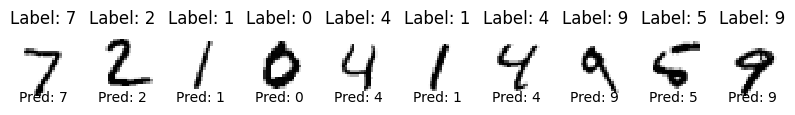

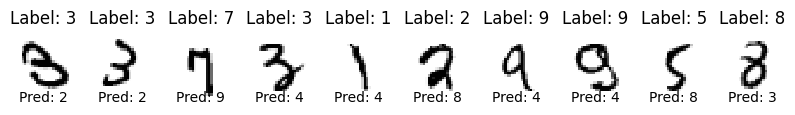



#########################
Training LR


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluation of  LR
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        42
           1       1.00      1.00      1.00        67
           2       0.98      0.98      0.98        55
           3       0.98      0.91      0.94        45
           4       1.00      0.98      0.99        55
           5       0.94      1.00      0.97        50
           6       0.98      0.95      0.96        43
           7       0.94      0.98      0.96        49
           8       1.00      0.93      0.96        40
           9       0.98      0.98      0.98        54

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


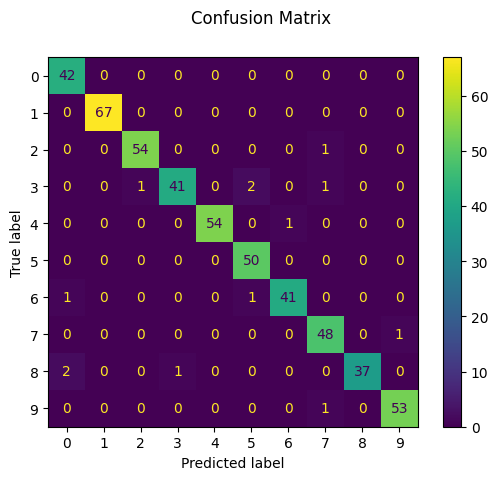

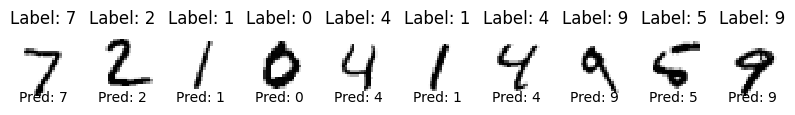

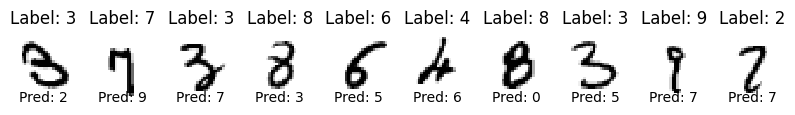



#########################
Training DT
Evaluation of  DT
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        42
           1       0.98      0.87      0.92        67
           2       0.36      0.15      0.21        55
           3       0.52      0.76      0.61        45
           4       0.69      0.87      0.77        55
           5       0.91      0.60      0.72        50
           6       0.83      0.67      0.74        43
           7       0.78      0.78      0.78        49
           8       0.32      0.57      0.41        40
           9       0.67      0.65      0.66        54

    accuracy                           0.68       500
   macro avg       0.69      0.67      0.66       500
weighted avg       0.70      0.68      0.67       500


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


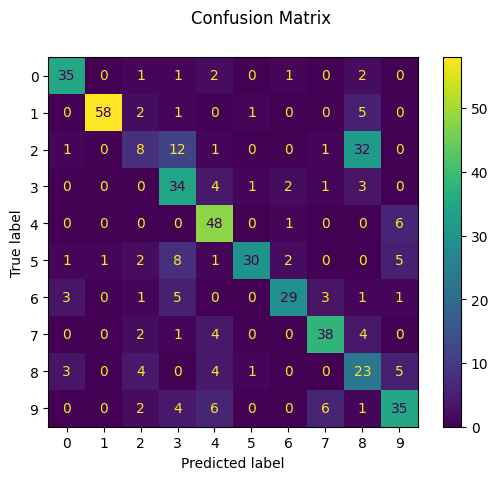

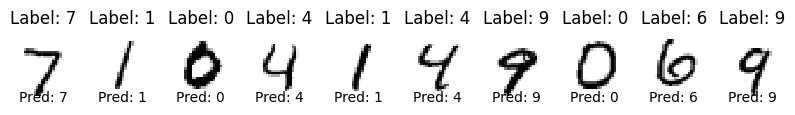

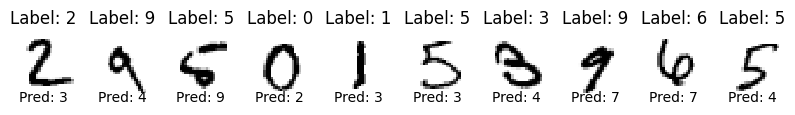



#########################
Training SVC


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Evaluation of  SVC
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        42
           1       1.00      1.00      1.00        67
           2       1.00      0.98      0.99        55
           3       1.00      1.00      1.00        45
           4       0.96      0.98      0.97        55
           5       0.98      1.00      0.99        50
           6       0.98      0.95      0.96        43
           7       0.96      1.00      0.98        49
           8       0.97      0.93      0.95        40
           9       1.00      0.94      0.97        54

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


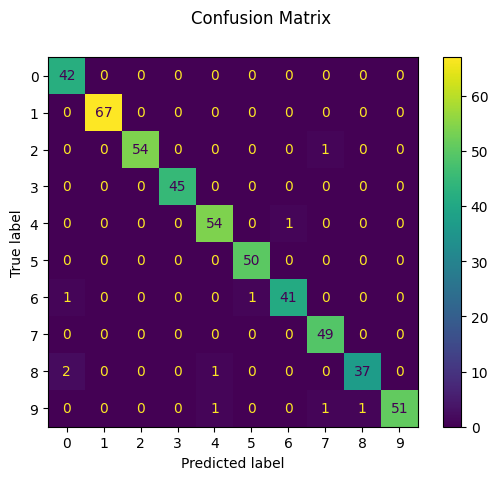

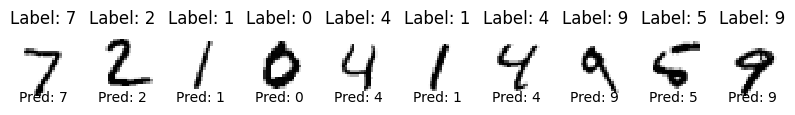

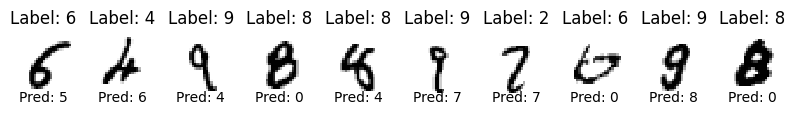



#########################
Training MLP
Evaluation of  MLP
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        42
           1       1.00      1.00      1.00        67
           2       0.96      0.96      0.96        55
           3       0.93      0.91      0.92        45
           4       0.96      0.98      0.97        55
           5       0.96      0.98      0.97        50
           6       0.98      0.98      0.98        43
           7       0.96      0.98      0.97        49
           8       1.00      0.90      0.95        40
           9       0.98      0.98      0.98        54

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


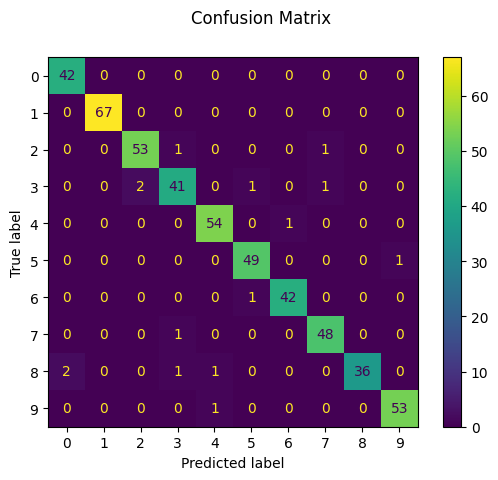

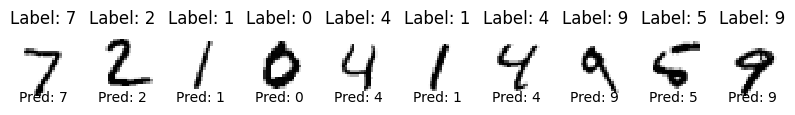

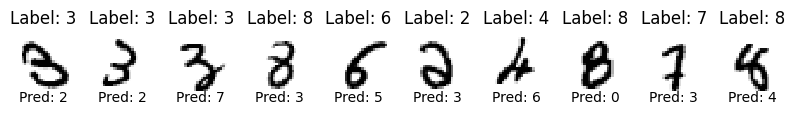

In [12]:
for name in models:
  print('#########################')
  print(f'Training {name}')

  train = data_norm_train
  test = data_norm_test

  model = models[name]
  model.fit(train, y_train[:N_SAMPLES_TRAIN])
  predicted = model.predict(test)

  performance_evaluation(y_test[:N_SAMPLES_TEST],predicted,name,figsize=(10,4))



**Now it's your turn!**

Utilize the Sign Language MNIST Dataset to build your own pipeline. Experiment with various features and classifiers to see what works best.

Download the dataset here: [www.ppgia.pucpr.br/~aghochuli/sign_mnist.zip](www.ppgia.pucpr.br/~aghochuli/sign_mnist.zip)


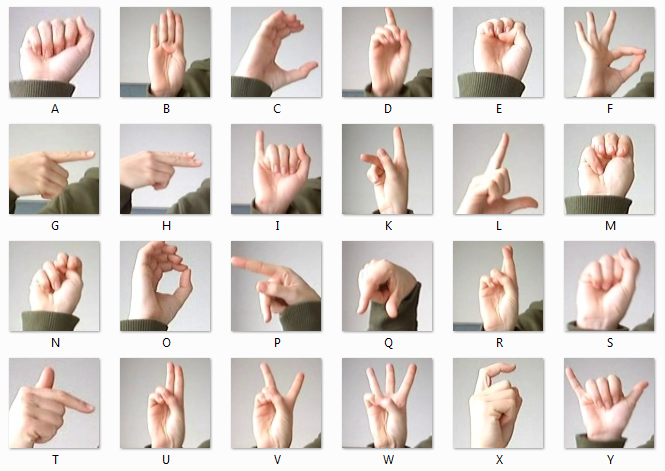


**Now it's your turn!**

Use the Simpsons Dataset to build your own pipeline. Experiment with different features and classifiers to determine what works best.

Download the dataset here: [www.ppgia.pucpr.br/~aghochuli/Simpsons.zip](www.ppgia.pucpr.br/~aghochuli/Simpsons.zip)

Additionally, compare the results between the Simpsons and Sign Language MNIST datasets.

Which dataset poses a greater challenge? Why do you think that is?


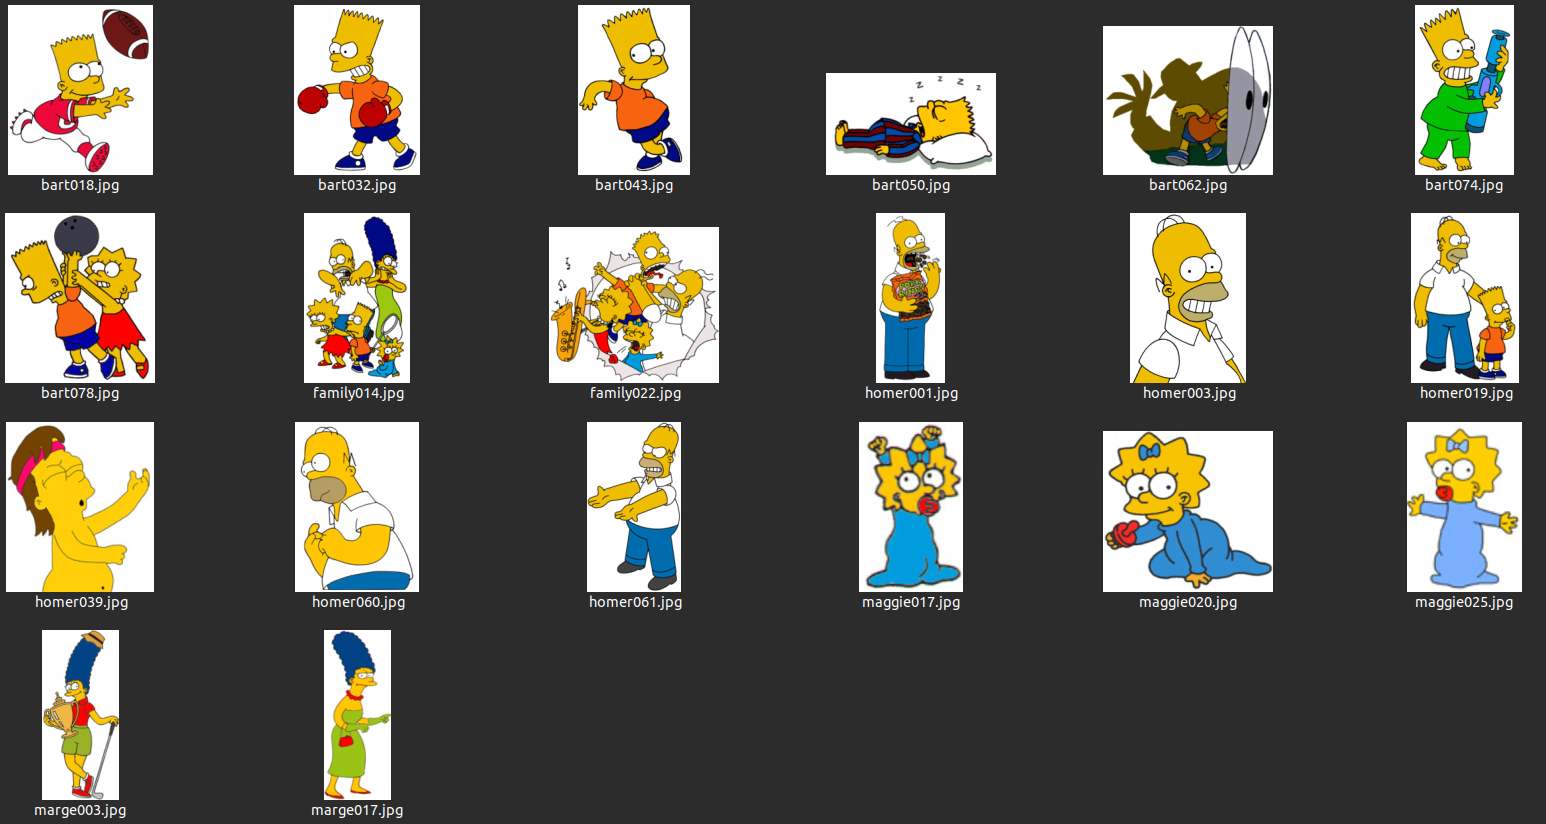